## 1. Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import datetime as dt
from scipy import stats

## 2. Load data

In [2]:
sheet_names = pd.ExcelFile('/lustre1/project/stg_00079/students/tingting/data/sun/supplementary_data/SupplementalTables.combined.xlsx').sheet_names
df=pd.read_excel('/lustre1/project/stg_00079/students/tingting/data/sun/supplementary_data/SupplementalTables.combined.xlsx', sheet_names[7])
df2=pd.read_excel('/lustre1/project/stg_00079/students/tingting/data/sun/supplementary_data/SupplementalTables.combined.xlsx', sheet_names[1])
all_min_frag=pd.read_csv('/lustre1/project/stg_00079/students/tingting/data/sun/snap2_allfragments/07/all_min_fragments_0.csv', header=None)

In [3]:
# transfer metadata into one 
all_min_frag=all_min_frag.rename(columns={0:'sampleID',1: 'min_frag', 2: 'num_cell' })
subject_ad2=df2.set_index("subject")["ADdiag2types"].to_dict()
subject_ad3=df2.set_index("subject")["ADdiag3types"].to_dict()
sample_min_frag=all_min_frag.set_index('sampleID')['min_frag'].to_dict()
sample_num_cell=all_min_frag.set_index('sampleID')['num_cell'].to_dict()

df['ADdiag2types'] = df['subject'].replace(subject_ad2)
df['ADdiag3types'] = df['subject'].replace(subject_ad3)
df['min_frag']=df['SampID'].replace(sample_min_frag)
df['num_cell']=df['SampID'].replace(sample_num_cell)

df.to_csv('/data/leuven/351/vsc35107/lustre1_stt/database/metadata/atac_metadata.csv')

In [4]:
meta=pd.read_csv('/data/leuven/351/vsc35107/lustre1_stt/database/metadata/atac_metadata.csv', index_col=0)

## 3. Numerical features

### 3.1 Outliers

In [5]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325 entries, 0 to 324
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subject       322 non-null    object
 1   SampID        325 non-null    object
 2   region        325 non-null    object
 3   age_death     325 non-null    int64 
 4   msex          325 non-null    object
 5   pmi           325 non-null    int64 
 6   ADdiag2types  325 non-null    object
 7   ADdiag3types  325 non-null    object
 8   min_frag      325 non-null    object
 9   num_cell      325 non-null    object
dtypes: int64(2), object(8)
memory usage: 27.9+ KB


In [6]:
meta['min_frag'] = pd.to_numeric(meta['min_frag'], errors='coerce' )
meta['num_cell'] = pd.to_numeric(meta['num_cell'], errors='coerce' )
meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325 entries, 0 to 324
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   subject       322 non-null    object 
 1   SampID        325 non-null    object 
 2   region        325 non-null    object 
 3   age_death     325 non-null    int64  
 4   msex          325 non-null    object 
 5   pmi           325 non-null    int64  
 6   ADdiag2types  325 non-null    object 
 7   ADdiag3types  325 non-null    object 
 8   min_frag      290 non-null    float64
 9   num_cell      290 non-null    float64
dtypes: float64(2), int64(2), object(6)
memory usage: 27.9+ KB


In [7]:
num_features=['age_death', 'pmi', 'min_frag', 'num_cell']

In [8]:
# 5 outliers for PMI

for feature in num_features:
    feature_mean = meta[feature].mean()  
    feature_std = meta[feature].std()  
    outliers = meta[feature].apply(lambda x: np.abs((x - feature_mean) / feature_std) > 3)
    print(feature, " outliers:")
    print(meta[outliers])  


age_death  outliers:
Empty DataFrame
Columns: [subject, SampID, region, age_death, msex, pmi, ADdiag2types, ADdiag3types, min_frag, num_cell]
Index: []
pmi  outliers:
          subject     SampID region  age_death    msex  pmi ADdiag2types  \
199  ROSMAP-50748  D19-13157    PFC         88    Male   19        nonAD   
202  ROSMAP-71282  D19-13160    PFC         87  Female   15           AD   
214  ROSMAP-38277  D19-13172    PFC         96    Male   13           AD   
223  ROSMAP-42986  D19-13181    PFC         78    Male   14           AD   
228  ROSMAP-10859  D19-13186    PFC         83    Male   14           AD   

    ADdiag3types  min_frag  num_cell  
199        nonAD    1031.0     285.0  
202      earlyAD    1008.0     202.0  
214      earlyAD    1130.0      97.0  
223      earlyAD    1009.0      86.0  
228       lateAD    1007.0      38.0  
min_frag  outliers:
          subject      SampID region  age_death    msex  pmi ADdiag2types  \
52   ROSMAP-20005   D19-12542     TH         

array([[<AxesSubplot: title={'center': 'age_death'}>,
        <AxesSubplot: title={'center': 'pmi'}>],
       [<AxesSubplot: title={'center': 'min_frag'}>,
        <AxesSubplot: title={'center': 'num_cell'}>]], dtype=object)

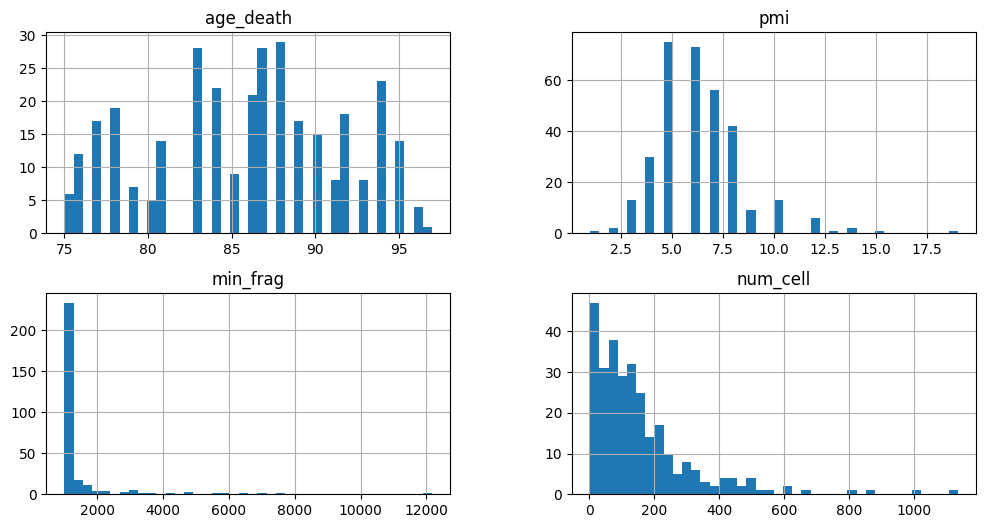

In [9]:
meta.hist(bins=40, figsize=(12,6))

## 4. Categorical features

In [10]:
cat_features = meta.select_dtypes('object').columns
cat_features

Index(['subject', 'SampID', 'region', 'msex', 'ADdiag2types', 'ADdiag3types'], dtype='object')

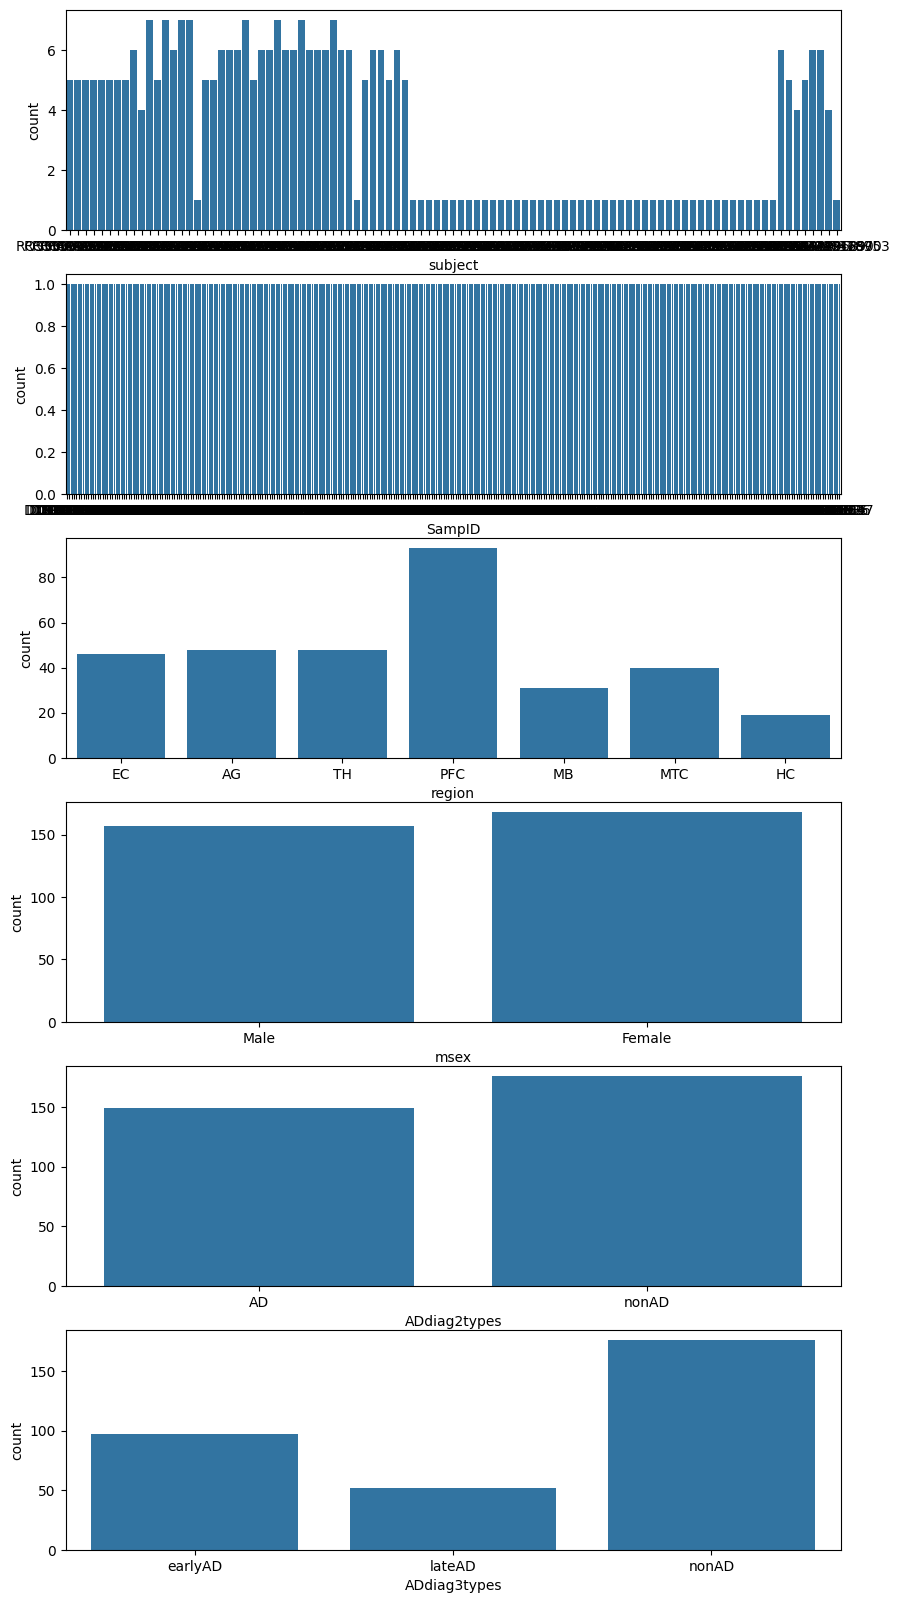

In [11]:
# visualise
fig, axs = plt.subplots(len(cat_features), 1, figsize=(10,20))
for i, column in enumerate(cat_features):
    sns.countplot(x = column, data = meta, ax=axs[i])

In [12]:
# subject with region number >6?
for i, column in enumerate(['subject']):
    counts = meta[column].value_counts()
    counts_gt_6 = counts[counts > 6]
    print(meta[meta[column].isin(counts_gt_6.index)])

          subject      SampID region  age_death    msex  pmi ADdiag2types  \
10   ROSMAP-41333  D19-122595     AG         76    Male    5        nonAD   
12   ROSMAP-20815  D19-122597     AG         86  Female    5        nonAD   
14   ROSMAP-66658  D19-122599     AG         90  Female    5        nonAD   
15   ROSMAP-77461  D19-122600     AG         95  Female    6        nonAD   
18   ROSMAP-41333  D19-122603     TH         76    Male    5        nonAD   
20   ROSMAP-20815  D19-122605     TH         86  Female    5        nonAD   
22   ROSMAP-66658  D19-122607     TH         90  Female    5        nonAD   
23   ROSMAP-77461  D19-122608     TH         95  Female    6        nonAD   
29   ROSMAP-20005   D19-12518    PFC         83  Female   10           AD   
40   ROSMAP-21853   D19-12530    PFC         83    Male    7        nonAD   
43   ROSMAP-97522   D19-12533    PFC         92  Female    7        nonAD   
52   ROSMAP-20005   D19-12542     TH         83  Female   10           AD   

In [13]:
## need to remove the rows from region MB
meta=meta[meta['region']!='MB']

In [14]:
meta.region.unique()

array(['EC', 'AG', 'TH', 'PFC', 'MTC', 'HC'], dtype=object)

In [15]:
for feature in cat_features:
    if not (feature=='subject' or feature=='SampID'):
        print(f"{feature}: {meta[feature].unique()}")

region: ['EC' 'AG' 'TH' 'PFC' 'MTC' 'HC']
msex: ['Male' 'Female']
ADdiag2types: ['AD' 'nonAD']
ADdiag3types: ['earlyAD' 'lateAD' 'nonAD']


### 4.1 Missingness

<AxesSubplot: >

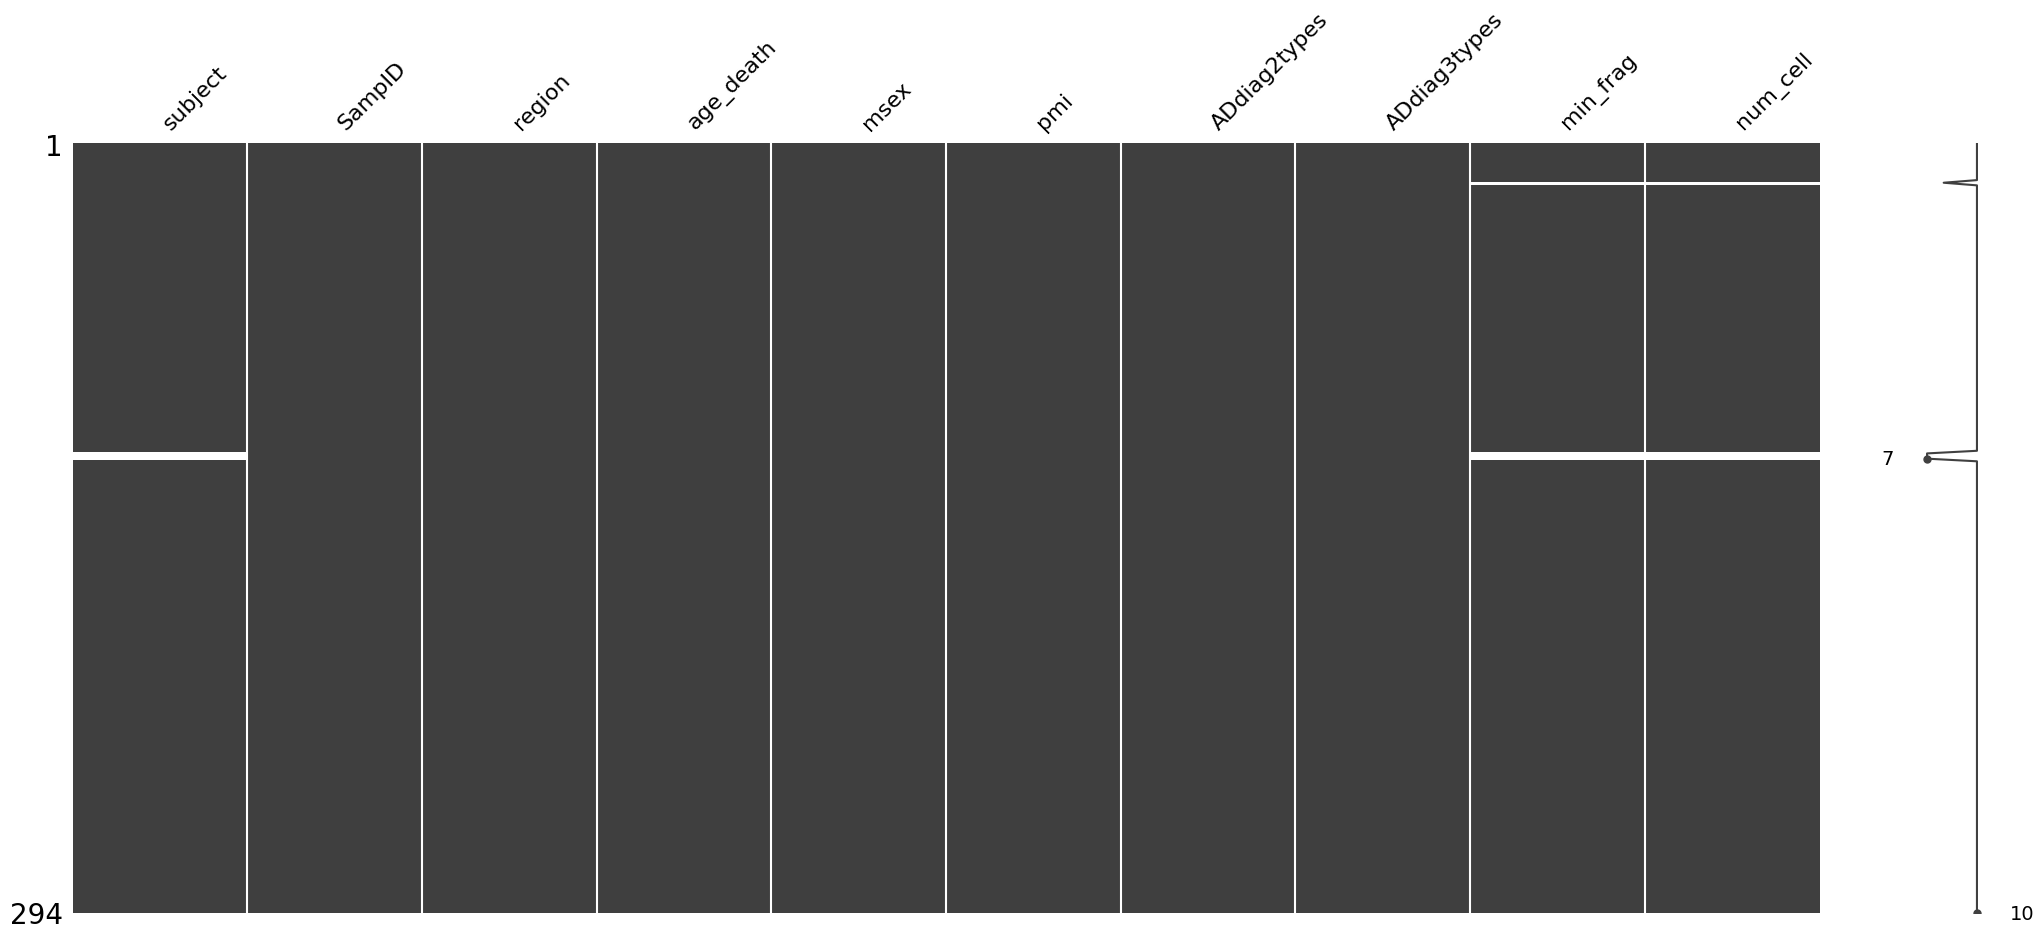

In [16]:
missingno.matrix(meta)

In [17]:
# drop NaN
meta=meta.dropna(axis=0)

In [19]:
meta.loc[meta['SampID']=='D19-122600', :]
meta.shape

(290, 10)

In [20]:
meta.to_csv('/data/leuven/351/vsc35107/lustre1_stt/database/metadata/atac_metadata_cleaned.csv')

## 5. Correlation

In [21]:
ad2_map={
    'AD':1,
    'nonAD':0
}

In [22]:
meta.ADdiag2types=meta.ADdiag2types.map(ad2_map)

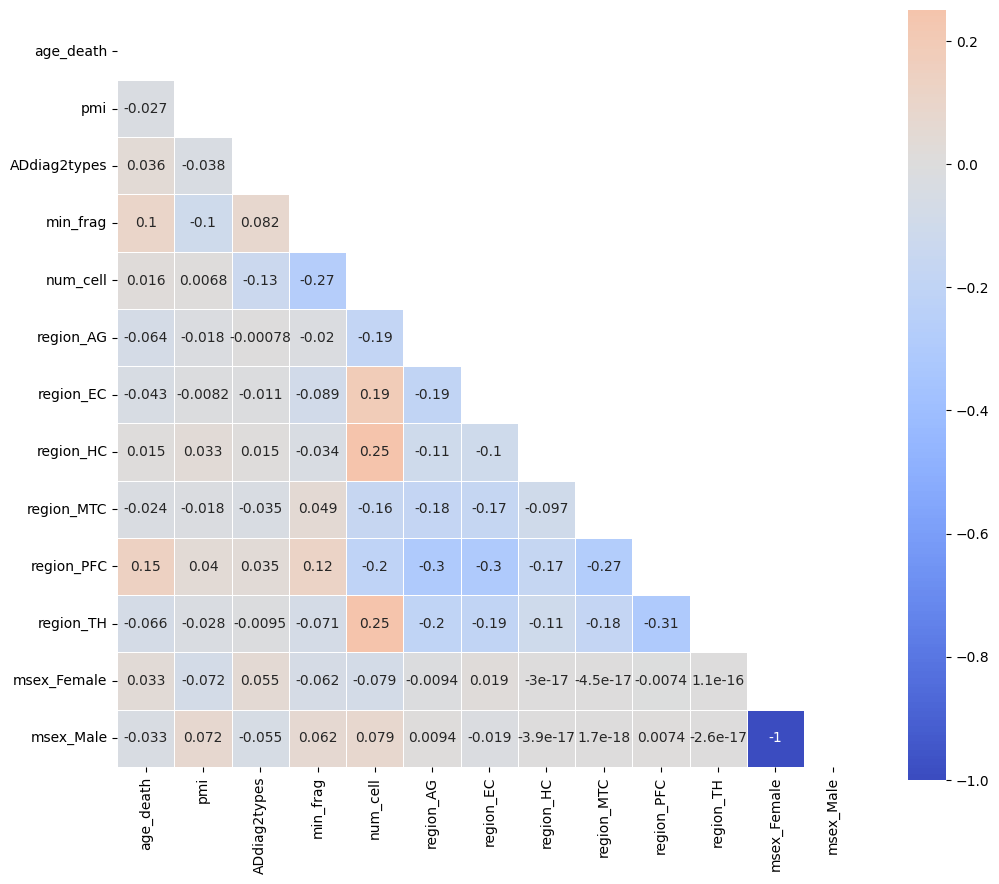

In [23]:
dff=meta.drop(['SampID', 'subject', 'ADdiag3types'], axis=1)
dff = pd.get_dummies(dff)

corr = dff.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))

sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=True, square=True, linewidths=.5, center=0)

# Show the plot
plt.show()